# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib

# Set up 

In [2]:
density = 1026 #Water density - kg/m3
c_p = 3850 #Specific heat of salt water - J/kgC
seconds = 7*24*60*60 #Time in a week - seconds
mlotst_equator = 21.95173968 # Mixed layer depth at equator - m

In [3]:
def white_noise(sigma):
    """
    Define white noise using a normal distribution
    
    """
    mean = 0
    std = sigma
    
    return np.random.normal(mean, std)

In [4]:
def integrate(params, years):
    """
    Integrating the white noise model 
    
    C dT/dt = -lambda T + F_o + F_a
    
    Inputs:
        params
            lambda_a = Atmospheric feedback
            sigma_a  = Variance of atmospheric forcing
            sigma_o  = Variance of oceanic forcing
            
    Outputs:
        T - Temperature [array]
        
    """
    lambda_a = params['lambda_a'] # Atmospheric feedback
    lambda_o = params['lambda_o']
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    Nt = 52*years # Number of timesteps - weekly [weeks]
    dt = 60*60*24*7 # Timestep - week [s]
    
    np.random.seed(0)
    
    T = np.zeros(Nt+1) # Temperature array over time [K]
    
    F_o = white_noise(sigma_o)
    Q_toa = np.zeros(Nt)
    Q_oce = np.zeros(Nt)
    for t in range(1,Nt):
        Q_oce[t] = -lambda_o*T[t] + white_noise(sigma_o) 
        Q_toa[t] = -lambda_a*T[t] + white_noise(sigma_a)
        T[t+1] = T[t] + (dt/(c_p*density*mlotst_equator))*(Q_toa[t] + Q_oce[t])
    
        
    return T    

In [5]:
def lag_regress(params, years, lagint):
    lambda_a = params['lambda_a'] # Atmospheric feedback
    lambda_o = params['lambda_o']
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    Nt = 52*years # Number of timesteps - weekly [weeks]
    dt = 60*60*24*7 # Timestep - week [s]
    
    np.random.seed(4)
    
    T = np.zeros(Nt+1) # Temperature array over time [K]
    
    F_o = white_noise(sigma_o)
    Q_toa = np.zeros(Nt)
    Q_oce = np.zeros(Nt)
    for t in range(1,Nt):
        Q_oce[t] = -lambda_o*T[t] + white_noise(sigma_o) 
        Q_toa[t] = -lambda_a*T[t] + white_noise(sigma_a)
        T[t+1] = T[t] + (dt/(c_p*density*mlotst_equator))*(Q_toa[t] + Q_oce[t])
    
    lag_series = np.arange(-lagint,lagint,1)
    lagresponse_toa = np.zeros(len(lag_series))
    lagresponse_oce = np.zeros(len(lag_series))
    i = 0
    for lag in lag_series:
        if lag < 0:
            laggedtoa = Q_toa[0:lag]
            laggedoce = Q_oce[0:lag]
            T_trunc = np.roll(T, lag)[0:lag-1]
        elif lag == 0:
            laggedtoa = Q_toa
            laggedoce = Q_oce
            T_trunc = T[:-1]
        elif lag > 0:    
            laggedoce = np.roll(Q_oce,-lag)[0:-lag]
            laggedtoa = np.roll(Q_toa,-lag)[0:-lag]
            T_trunc = T[0:-lag-1]
        lagresponse_toa[i] = np.polyfit(T_trunc, laggedtoa, deg=1)[0]
        lagresponse_oce[i] = np.polyfit(T_trunc, laggedoce, deg=1)[0]
        i += 1
        
    return lagresponse_toa, lagresponse_oce, lag_series

In [6]:
def plot(params, years, T):
    fig, ax = plt.subplots()
    ax.plot(np.arange(years*52+1), T)
    ax.set_xticks(np.arange(0,years*52+1,52*100), np.arange(0,years+1,100))
    ax.set_title((r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' + str(params['sigma_o']) + r'  $\lambda_a$:' 
                  + str(params['lambda_a']) + r'  $\lambda_o$:' + str(params['lambda_o'])))
    ax.set_xlabel('Time [years]')
    ax.set_ylabel('Temperature Anomaly [K]')
    fig.show()

# Tests

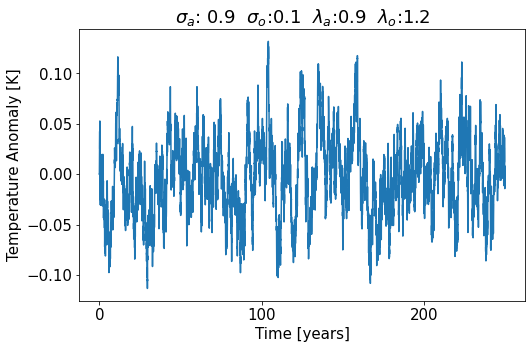

In [48]:
# sigma_a > sigma_o
params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 1.2
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 250
lagint = 52*2

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

plt.rcParams['figure.figsize'] = [8, 5]
T = integrate(params, years)
plot(params, years, T)

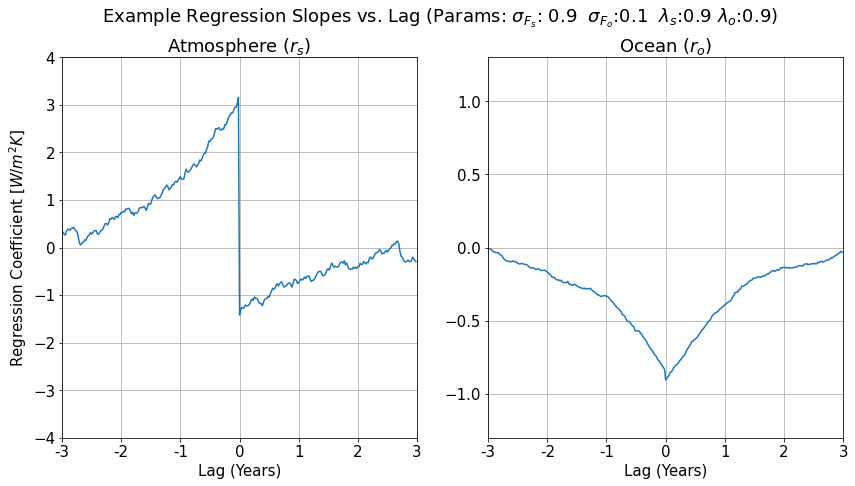

In [12]:
# sigma_a > sigma_o
params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 250
lagint = 52*3

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
ax.set_ylim(-4,4)
ax.set_xticks(np.arange(-52*3,52*4,52), np.arange(-3,4,1))
ax.set_xlim(-52*3,52*3)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression Coefficient [$W/m^2K$]')
ax.set_title(r'Atmosphere ($r_s$)')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*3,52*4,52), np.arange(-3,4,1))
ax2.set_xlim(-3*52,3*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_title(r'Ocean ($r_o$)')
plt.suptitle('Example Regression Slopes vs. Lag (Params: ' + r'$\sigma_{F_s}$: ' + str(params['sigma_a']) + r'  $\sigma_{F_o}$:' +
                                              str(params['sigma_o']) + r'  $\lambda_s$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

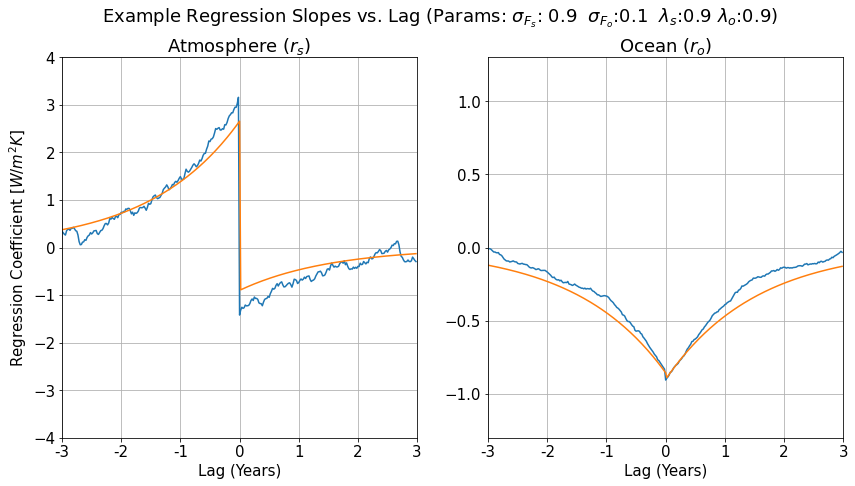

In [15]:
# sigma_a > sigma_o
params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 250
lagint = 52*3

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)
analytic_atmos, analytic_ocean = analytical(params, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)

font = {'size'   : 15,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

ax.plot(lagseries, lagresponse_toa)
ax.plot(lagseries, analytic_atmos)
ax.set_ylim(-4,4)
ax.set_xticks(np.arange(-52*3,52*4,52), np.arange(-3,4,1))
ax.set_xlim(-52*3,52*3)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel(r'Regression Coefficient [$W/m^2K$]')
ax.set_title(r'Atmosphere ($r_s$)')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.plot(lagseries, analytic_ocean)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*3,52*4,52), np.arange(-3,4,1))
ax2.set_xlim(-3*52,3*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_title(r'Ocean ($r_o$)')

plt.suptitle('Example Regression Slopes vs. Lag (Params: ' + r'$\sigma_{F_s}$: ' + str(params['sigma_a']) + r'  $\sigma_{F_o}$:' +
                                              str(params['sigma_o']) + r'  $\lambda_s$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

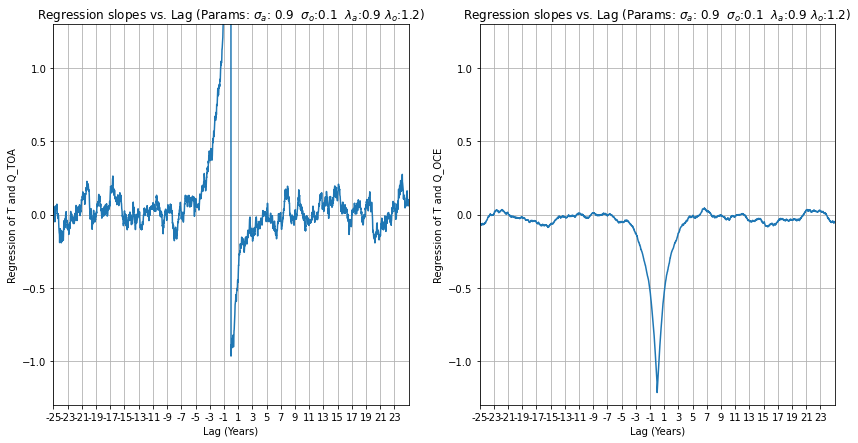

In [20]:
# sigma_a > sigma_o
params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 1.2
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
ax.set_ylim(-1.3,1.3)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                     + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax2.set_xlim(-25*52,25*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

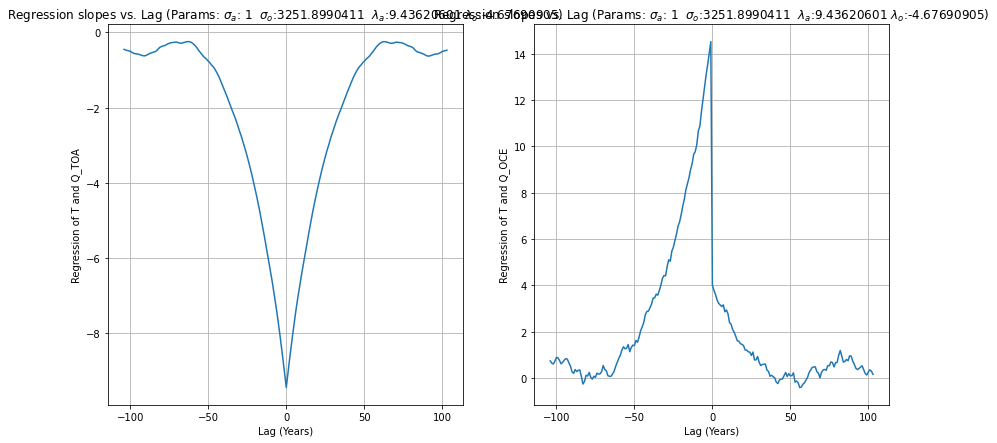

In [12]:
# sigma_a = sigma_o
params = {}
params['lambda_a'] = 9.43620601
params['lambda_o'] = -4.67690905
params['sigma_a'] = 1
params['sigma_o'] = 3251.8990411
years = 125
lagint = 52*2

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)

# Atmos
plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
#ax.set_ylim(-1.3,1.3)
#ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
#ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
#ax2.set_ylim(-1.3,1.3)
#ax2.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
#ax2.set_xlim(-25*52,25*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

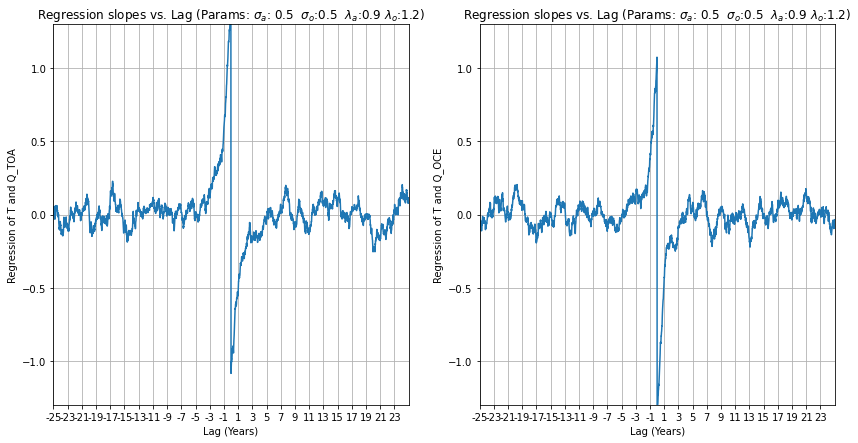

In [22]:
# sigma_a = sigma_o
params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 1.2
params['sigma_a'] = 0.5
params['sigma_o'] = 0.5
years = 1000
lagint = 52*25

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)

# Atmos
plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
ax.set_ylim(-1.3,1.3)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax2.set_xlim(-25*52,25*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

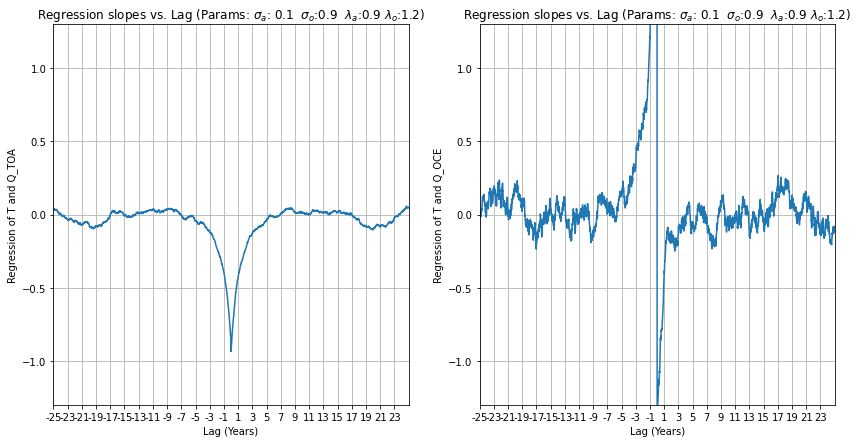

In [21]:
# sigma_o > sigma_a

params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 1.2
params['sigma_a'] = 0.1
params['sigma_o'] = 0.9
years = 1000
lagint = 52*25

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
ax.set_ylim(-1.3,1.3)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                     + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax2.set_xlim(-25*52,25*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

# Analytical Solution

In [14]:
# Analytical solution

def analytical(params, lagint):
    lambda_o = params['lambda_o'] # Ocean feedback
    lambda_a = params['lambda_a'] # Atmospheric feedback
    sigma_a = params['sigma_a']   # Variance of atmospheric forcing
    sigma_o = params['sigma_o']   # Variance of oceanic forcing
    
    dt = 60*60*24*7 # Timestep - week [s]
        
    lag_series = np.arange(-lagint,lagint,1)*dt
        
    c = c_p*density*mlotst_equator # Heat capacity
    
    w_0 = (lambda_a + lambda_o)/c

    eq_secondhalf = (lambda_a + lambda_o) * 2/(sigma_a**2+sigma_o**2) * np.exp(-w_0*abs(lag_series))
    
    for i in range(len(eq_secondhalf)):
        if lag_series[i]>0:
            eq_secondhalf[i] = 0
        else:
            eq_secondhalf[i] = eq_secondhalf[i]
        
    # r_analytical = -np.exp(-lambda_a*abs(lag_series*dt)/c)*lambda_a
    r_atmos = -lambda_a*np.exp(-w_0*abs(lag_series)) + (eq_secondhalf)*sigma_a**2
    r_ocean = -lambda_o*np.exp(-w_0*abs(lag_series)) + (eq_secondhalf)*sigma_o**2

    return r_atmos, r_ocean

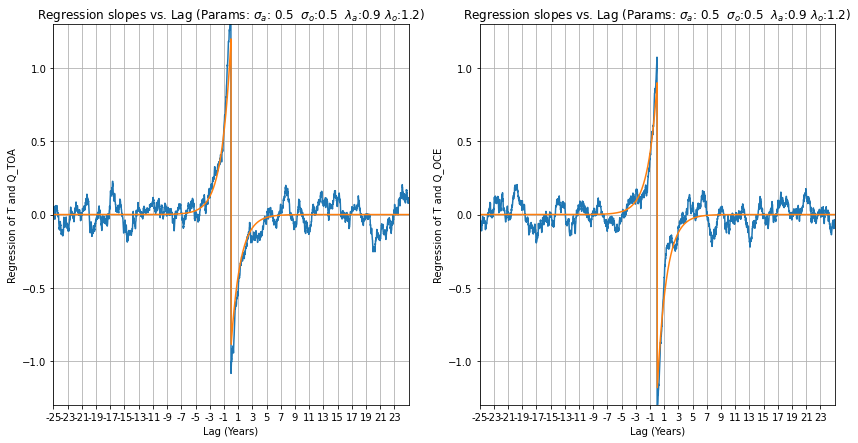

In [13]:
# sigma_a = sigma_o
params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 1.2
params['sigma_a'] = 0.5
params['sigma_o'] = 0.5
years = 1000
lagint = 52*25

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)
analytic_atmos, analytic_ocean = analytical(params, lagint)


# Atmos
plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
ax.plot(lagseries, analytic_atmos)
ax.set_ylim(-1.3,1.3)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.plot(lagseries, analytic_ocean)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax2.set_xlim(-25*52,25*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

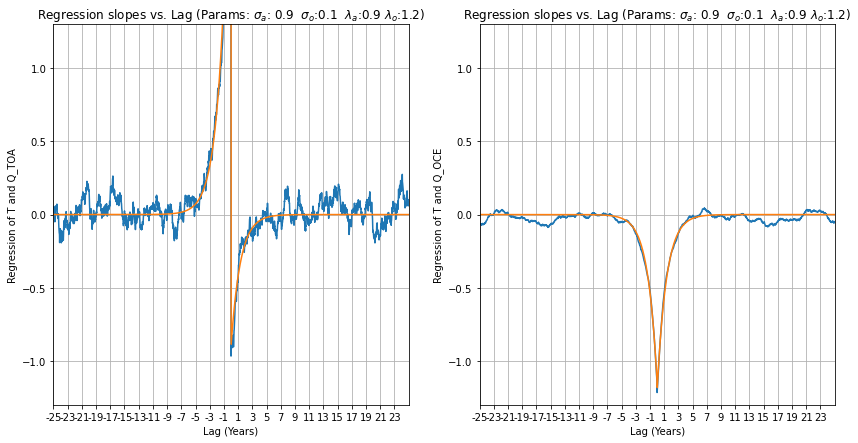

In [14]:
# sigma_a > sigma_o
params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 1.2
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1
years = 1000
lagint = 52*25

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)
analytic_atmos, analytic_ocean = analytical(params, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
ax.plot(lagseries, analytic_atmos)
ax.set_ylim(-1.3,1.3)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                     + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.plot(lagseries, analytic_ocean)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax2.set_xlim(-25*52,25*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

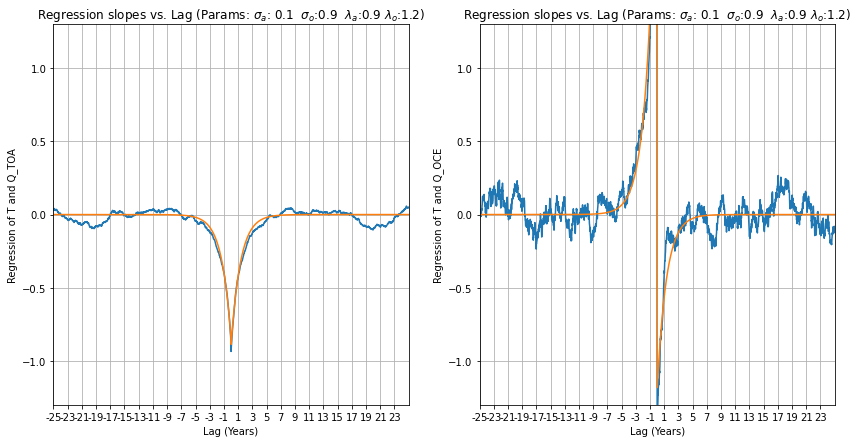

In [15]:
# sigma_o > sigma_a

params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 1.2
params['sigma_a'] = 0.1
params['sigma_o'] = 0.9
years = 1000
lagint = 52*25

lagresponse_toa, lagresponse_oce, lagseries = lag_regress(params, years, lagint)
analytic_atmos, analytic_ocean = analytical(params, lagint)

plt.rcParams['figure.figsize'] = [14, 7]
fig, (ax,ax2) = plt.subplots(1,2)
ax.plot(lagseries, lagresponse_toa)
ax.plot(lagseries, analytic_atmos)
ax.set_ylim(-1.3,1.3)
ax.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax.set_xlim(-25*52,25*52)
ax.set_xlabel('Lag (Years)')
ax.set_ylabel('Regression of T and Q_TOA')
ax.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                     + r' $\lambda_o$:' + str(params['lambda_o']) + ')')
ax.grid()

# Ocean
ax2.plot(lagseries, lagresponse_oce)
ax2.plot(lagseries, analytic_ocean)
ax2.set_ylim(-1.3,1.3)
ax2.set_xticks(np.arange(-52*25,52*25,52*2), np.arange(-25,25,2))
ax2.set_xlim(-25*52,25*52)
ax2.set_xlabel('Lag (Years)')
ax2.set_ylabel('Regression of T and Q_OCE')
ax2.set_title('Regression slopes vs. Lag (Params: ' + r'$\sigma_a$: ' + str(params['sigma_a']) + r'  $\sigma_o$:' +
                                              str(params['sigma_o']) + r'  $\lambda_a$:' + str(params['lambda_a']) 
                                                 + r' $\lambda_o$:' + str(params['lambda_o']) + ')')

#ax2.set_xticks(np.arange(0,1.1,0.2),np.arange(0,1.1,0.2))
ax2.grid()

In [8]:
def make_fig(ax, d=False):
    ax.set_ylim(-2,2)
    if d == True:
        ax.set_ylabel('Regression Coefficients')
        ax.set_yticks(np.arange(-2,2,0.5))
        ax.text(0.5,2.1,r'$r_s$')
    else:
        plt.tick_params(left = False, labelleft = False)
        ax.text(0.5,2.1,r'$r_o$')
    ax.set_xticks(np.arange(-52*4,52*5,52), np.arange(-4,5,1))
    ax.set_xlim(-5*52,5*52)
    ax.set_xlabel('Lag (Years)')
    #ax1.set_title('')
    ax.grid()

Text(0.7, 0.9, '$\\lambda_s \\gg \\lambda_o$')

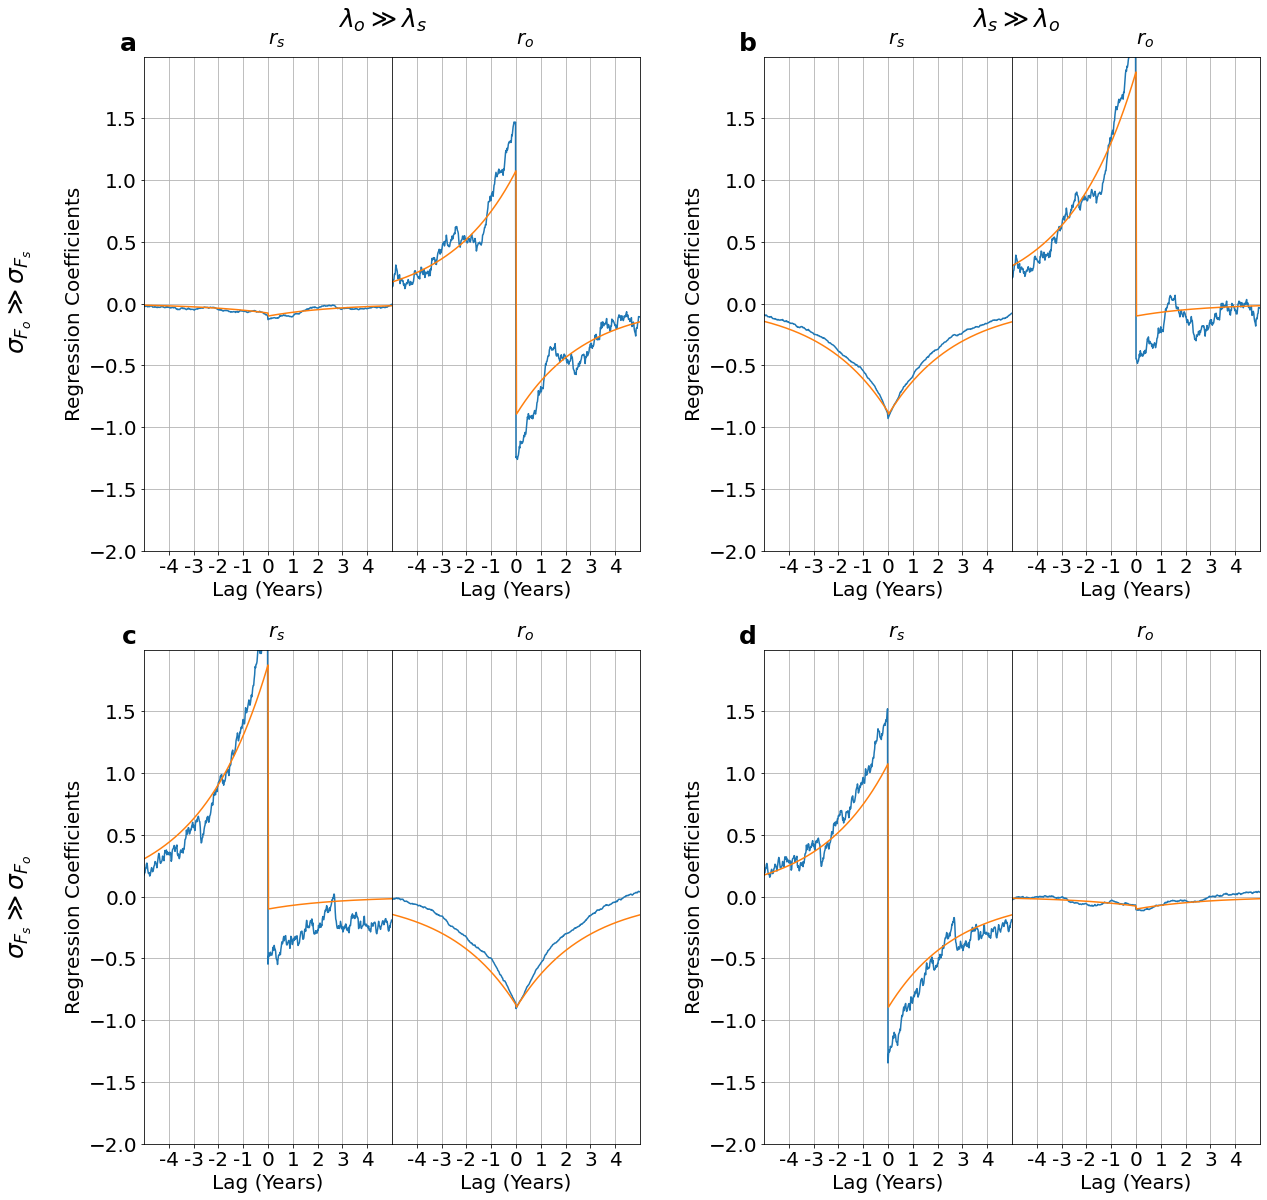

In [10]:
# sigma_o > sigma_a

fig = plt.figure(figsize=(20, 20))
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=9, width_ratios=[2,2,2,2,2,2,2,2,2], wspace=0)
font = {'size'   : 20,
        'weight' : 'normal'}

matplotlib.rc('font', **font)

params = {}
params['lambda_a'] = 0.1
params['lambda_o'] = 0.9
params['sigma_a'] = 0.1
params['sigma_o'] = 0.9
years = 250
lagint = 52*5

lr_toa_sala, lr_oce_sala, ls_sala = lag_regress(params, years, lagint)
an_atm_sala, an_oce_sala = analytical(params, lagint)

ax1 = fig.add_subplot(gs[0,0:2])
ax1.plot(ls_sala, lr_toa_sala)
ax1.plot(ls_sala, an_atm_sala)
ax1.text(-0.03, 1.05, 'a', transform=ax1.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')
make_fig(ax1,True)

ax2 = fig.add_subplot(gs[0,2:4])
ax2.plot(ls_sala, lr_oce_sala)
ax2.plot(ls_sala, an_oce_sala)
make_fig(ax2)

params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 0.1
params['sigma_a'] = 0.1
params['sigma_o'] = 0.9

lr_toa_salo, lr_oce_salo, ls_salo = lag_regress(params, years, lagint)
an_atm_salo, an_oce_salo = analytical(params, lagint)

ax3 = fig.add_subplot(gs[0,5:7])
ax3.plot(ls_salo, lr_toa_salo)
ax3.plot(ls_salo, an_atm_salo)
ax3.text(-0.03, 1.05, 'b', transform=ax3.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')
make_fig(ax3,True)

ax4 = fig.add_subplot(gs[0,7:9])
ax4.plot(ls_salo, lr_oce_salo)
ax4.plot(ls_salo, an_oce_salo)
make_fig(ax4)

params = {}
params['lambda_a'] = 0.1
params['lambda_o'] = 0.9
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1

lr_toa_sola, lr_oce_sola, ls_sola = lag_regress(params, years, lagint)
an_atm_sola, an_oce_sola = analytical(params, lagint)

ax5 = fig.add_subplot(gs[1,0:2])
ax5.plot(ls_sola, lr_toa_sola)
ax5.plot(ls_sola, an_atm_sola)
ax5.text(-0.03, 1.05, 'c', transform=ax5.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')
make_fig(ax5,True)

ax6 = fig.add_subplot(gs[1,2:4])
ax6.plot(ls_sola, lr_oce_sola)
ax6.plot(ls_sola, an_oce_sola)
make_fig(ax6)

params = {}
params['lambda_a'] = 0.9
params['lambda_o'] = 0.1
params['sigma_a'] = 0.9
params['sigma_o'] = 0.1

lr_toa_solo, lr_oce_solo, ls_solo = lag_regress(params, years, lagint)
an_atm_solo, an_oce_solo = analytical(params, lagint)

ax7 = fig.add_subplot(gs[1,5:7])
ax7.plot(ls_solo, lr_toa_solo)
ax7.plot(ls_solo, an_atm_solo)
ax7.text(-0.03, 1.05, 'd', transform=ax7.transAxes,
      fontsize=25, fontweight='bold', va='top', ha='right')
make_fig(ax7,True)

ax8 = fig.add_subplot(gs[1,7:9])
ax8.plot(ls_solo, lr_oce_solo)
ax8.plot(ls_solo, an_oce_solo)
make_fig(ax8)

fig.text(0.03,0.68,r'$\sigma_{F_o} \gg \sigma_{F_s}$', rotation='vertical', fontsize=25)
fig.text(0.03,0.26,r'$\sigma_{F_s} \gg \sigma_{F_o}$', rotation='vertical', fontsize=25)
fig.text(0.26,0.9,r'$\lambda_o \gg \lambda_s$', fontsize=25)
fig.text(0.7,0.9,r'$\lambda_s \gg \lambda_o$', fontsize=25)